In [ ]:
import torch

In [ ]:
import torch.nn as nn

In [ ]:
import torch.optim as optim

In [ ]:
from torch.utils import data

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
import torchvision.transforms as transforms

In [ ]:
import cv2

In [ ]:
import numpy as np

In [ ]:
import csv

In [ ]:
samples = []
with open('drive/My Drive/Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

In [ ]:
len(samples)

7251

In [ ]:
samples[1][1]

'D:\\Self Driving Car\\Data\\IMG\\left_2020_06_12_01_43_48_965.jpg'

In [ ]:
train_len = int(0.8*len(samples))
valid_len = len(samples) - train_len
train_samples, validation_samples = data.random_split(samples, lengths=[train_len, valid_len])

In [ ]:
name = 'D:\\Image\\Hello'

In [ ]:
name = "drive/My Drive/Data/IMG/left_2020_06_12_01_43_48_965.jpg"

In [ ]:
pip install Pillow

In [ ]:
from PIL import Image

In [ ]:
img = cv2.imread(name)

In [ ]:
img

array([[[ 59, 109,  97],
        [ 73, 121, 109],
        [ 81, 121, 110],
        ...,
        [ 62,  63,  59],
        [ 51,  52,  48],
        [ 49,  50,  46]],

       [[ 64, 114, 102],
        [ 74, 122, 110],
        [ 78, 118, 107],
        ...,
        [ 56,  57,  53],
        [ 44,  45,  41],
        [ 44,  45,  41]],

       [[ 67, 117, 105],
        [ 73, 121, 109],
        [ 76, 116, 105],
        ...,
        [ 48,  49,  45],
        [ 38,  39,  35],
        [ 36,  37,  33]],

       ...,

       [[125, 125, 125],
        [122, 122, 122],
        [122, 122, 122],
        ...,
        [189, 185, 180],
        [192, 188, 183],
        [192, 188, 183]],

       [[123, 123, 123],
        [119, 119, 119],
        [117, 117, 117],
        ...,
        [183, 177, 172],
        [189, 183, 178],
        [195, 189, 184]],

       [[116, 116, 116],
        [112, 112, 112],
        [108, 108, 108],
        ...,
        [190, 184, 179],
        [190, 184, 179],
        [176, 170, 165]]

In [ ]:
img[65:-25, :, :]

array([[[ 29,  34,  25],
        [ 32,  37,  28],
        [ 37,  40,  31],
        ...,
        [ 40,  39,  35],
        [ 39,  36,  32],
        [ 34,  31,  27]],

       [[ 28,  33,  24],
        [ 33,  38,  29],
        [ 39,  42,  33],
        ...,
        [ 41,  40,  36],
        [ 40,  37,  33],
        [ 32,  29,  25]],

       [[ 30,  35,  26],
        [ 36,  39,  30],
        [ 42,  43,  34],
        ...,
        [ 32,  31,  27],
        [ 33,  30,  26],
        [ 35,  32,  28]],

       ...,

       [[129, 131, 132],
        [127, 129, 130],
        [125, 127, 128],
        ...,
        [163, 166, 170],
        [162, 165, 169],
        [161, 164, 168]],

       [[126, 128, 129],
        [126, 128, 129],
        [125, 127, 128],
        ...,
        [160, 163, 167],
        [164, 167, 171],
        [167, 170, 174]],

       [[124, 126, 127],
        [125, 127, 128],
        [125, 127, 128],
        ...,
        [158, 163, 166],
        [161, 166, 169],
        [164, 169, 172]]

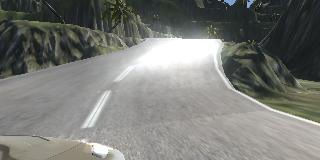

In [ ]:
Image.open("drive/My Drive/Data/IMG/right_2020_06_12_01_43_48_965.jpg")

In [ ]:
def augment(imgName, angle):
  name = 'drive/My Drive/Data/IMG/' + imgName.split('//')[-1]
  current_image = cv2.imread(name)
  current_image = current_image[65:-25, :, :]
  if np.random.rand() < 0.5:
    current_image = cv2.flip(current_image, 1)
    angle = angle * -1.0  
  return current_image, angle

In [ ]:
class Dataset(data.Dataset):

    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
        batch_samples = self.samples[index]
        steering_angle = float(batch_samples[3])
        center_img, steering_angle_center = augment(batch_samples[0], steering_angle)
        left_img, steering_angle_left = augment(batch_samples[1], steering_angle + 0.4)
        right_img, steering_angle_right = augment(batch_samples[2], steering_angle - 0.4)
        center_img = self.transform(center_img)
        left_img = self.transform(left_img)
        right_img = self.transform(right_img)
        return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)
      
    def __len__(self):
        return len(self.samples)
                                     

In [ ]:
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])

params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 4}

training_set = Dataset(train_samples, transformations)
training_generator = DataLoader(training_set, **params)

validation_set = Dataset(validation_samples, transformations)
validation_generator = DataLoader(validation_set, **params)

In [ ]:
class NetworkLight(nn.Module):

    def __init__(self):
        super(NetworkLight, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 48, 3, stride=2),
            nn.MaxPool2d(4, stride=4),
            nn.Dropout(p=0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48*4*19, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        

    def forward(self, input):
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [ ]:
model = NetworkLight()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)

def toDevice(datas, device):
  
  imgs, angles = datas
  return imgs.float().to(device), angles.float().to(device)

device is:  cuda


In [ ]:
max_epochs = 22
for epoch in range(max_epochs):
    model.to(device)
    
    # Training
    train_loss = 0
    model.train()
    for local_batch, (centers, lefts, rights) in enumerate(training_generator):
        # Transfer to GPU
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
        
        # Model computations
        optimizer.zero_grad()
        datas = [centers, lefts, rights]        
        for data in datas:
            imgs, angles = data
#             print("training image: ", imgs.shape)
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0].item()
            
        if local_batch % 100 == 0:
            print('Loss: %.3f '
                % (train_loss/(local_batch+1)))

TypeError: ignored

In [ ]:
# Validation
model.eval()
valid_loss = 0
with torch.set_grad_enabled(False):
    for local_batch, (centers, lefts, rights) in enumerate(validation_generator):
          # Transfer to GPU
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
        
          # Model computations
        optimizer.zero_grad()
        datas = [centers, lefts, rights]        
        for data in datas:
            imgs, angles = data
#                print("Validation image: ", imgs.shape)
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))
                
            valid_loss += loss.data[0].item()

        if local_batch % 100 == 0:
            print('Valid Loss: %.3f '
                % (valid_loss/(local_batch+1)))
  

NameError: ignored